# Creating numeric Coil sensitivities and k space trajectories
### Importing necessary classes and functions

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys

import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.nn.functional import interpolate

sys.path.insert(0, "../../../src")

from juart.conopt.functional.fourier import nonuniform_fourier_transform_forward
from juart.parim.analytic import cyclic_head_coil
from juart.phantoms.mni import BrainPhantom5D
from juart.sampling.spherical import spherical_trajectory_3d
from juart.vis.interactive import InteractiveFigure3D, InteractiveFigure4D
import zarr

### Creating numerical image of the Brain
A 5D phantom will be created nX, nY, nZ, nTI, nTE. 

In [2]:
phantom = BrainPhantom5D(
    B0=3,
    B0_shimming=True,
)

Constructing Numerical Brain Phantom ...


In [3]:
dTE, TE0, nTE = 5, 5, 1
dTI, TI0, nTI = 100, 20, 1

TE = TE0 + dTE * np.arange(nTE)
TI = TI0 + dTI * np.arange(nTI)

TR = 1e6
IE = 1

### Creating x_image from the phantom
The signal function will create one or multiple echo images from the phantom. The T parameters from the cell above will determine how many images and at which time of the decay process.

In [4]:
x_image = phantom.signal(TI, TE, TR, IE)
x_image = x_image / np.abs(x_image).max()
x_image = torch.from_numpy(x_image).to(torch.complex64)

### Reduce resolution
Unfortunately its for memory reasons necessary to decrease the resolution. The interpolate function can do this but just for real values and not for complex. That is why the interpolation is split in real and imaginary part and then its sticked back together to get the complex x image back again.

In [5]:
x_image = torch.complex(
    interpolate(x_image[None, None, ..., 0, 0].real, (128, 128, 128)),
    interpolate(x_image[None, None, ..., 0, 0].imag, (128, 128, 128)),
)[0, 0, ..., None, None]

### Plot of the x image

interactive(children=(IntSlider(value=64, description='Dimension 3', max=128, min=1), Output()), _dom_classes=…

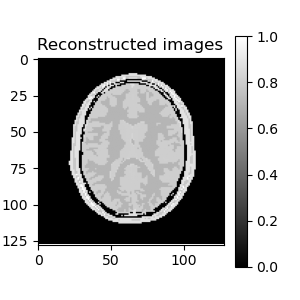

In [6]:
InteractiveFigure3D(
    torch.abs(x_image[..., 0, 0]).cpu().numpy(),
    vmin=0,
    vmax=1,
    title="Reconstructed images",
    cmap="gray",
).interactive

### Create a spherical trajectory
The spherical trajectory of the kspace is created and its possible to set the resolution of the kspace. The second argument will decide how many samples there are. If undersampling is desired, it is possible to do this with the second argument.

In [7]:
k_unraveled = spherical_trajectory_3d(128, 128*4)

#### Draw plot of the just created kspace trajectories

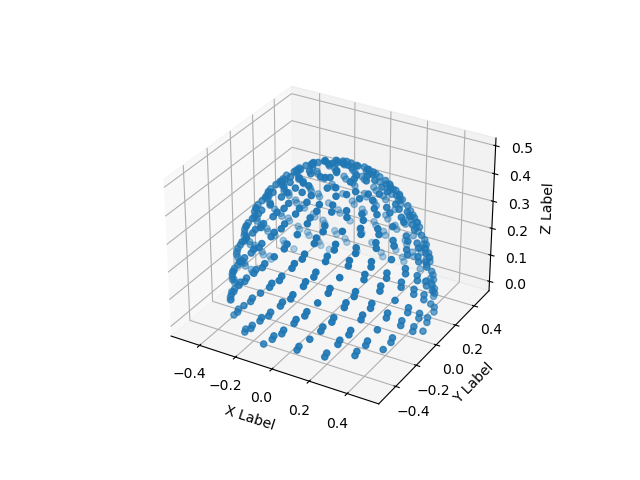

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.scatter(
    k_unraveled[0, -1, :],
    k_unraveled[1, -1, :],
    k_unraveled[2, -1, :],
)

ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.set_zlabel("Z Label")

plt.show()

In [9]:
k = k_unraveled.reshape((3, -1))

### Create coil sensitivities for a head coil with 8 channels

In [10]:
C = cyclic_head_coil((8, 128, 128, 128))

#### Create the parts of the image that every single coil acquires

In [11]:
coil_images = C * x_image[None, ..., 0, 0]

### Illustration of the image parts of the single coils

interactive(children=(IntSlider(value=64, description='Slice', max=128, min=1), IntSlider(value=4, description…

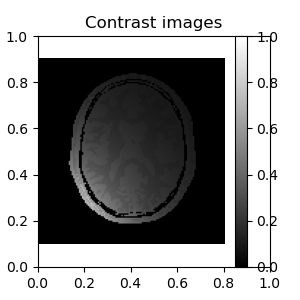

In [12]:
InteractiveFigure4D(
    torch.abs(coil_images).numpy(),
    vmin=0,
    vmax=1,
    title="Contrast images",
    axes=(1, 2, 3, 0),
    cmap="gray",
    description=("Slice", "Channel"),
).interactive

### Computing k space data out of the images
The computed kspace data contains the signal of every single coil at every specific location (nC, nX * nY * nZ).

In [13]:
d = nonuniform_fourier_transform_forward(
    k,
    coil_images,
    isign=-1,
)

In [14]:
C.shape, k.shape ,d.shape

(torch.Size([8, 128, 128, 128]),
 torch.Size([3, 65536]),
 torch.Size([8, 65536]))

### Saving
Saving the variables that were just created. 
- C (nC, nX, nY ,nZ)
- k (ndim, nX * nY * nZ)
- d (nC, nX * nY * nZ)

In [15]:
store = zarr.storage.LocalStore("/home/jovyan/datasets/num_phantom_128_R32")

In [16]:
group = zarr.create_group(
    store,
    overwrite=True,
)

In [17]:
group.create_array(
    "C",
    shape=C.shape,
    dtype=np.complex64,
    overwrite=True,
)
group.create_array(
    "k", 
    shape=k.shape,
    dtype=np.float32,
    overwrite=True,
)
group.create_array(
    "d", 
    shape=d.shape,
    dtype=np.complex64,
    overwrite=True,
)

<Array file:///home/jovyan/datasets/num_phantom_128_R32/d shape=(8, 65536) dtype=complex64>

In [18]:
group["C"] = C.numpy()

In [19]:
group["k"] = k.numpy()

In [20]:
group["d"] = d.numpy()